## Inicialización

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator




## Carga los datos

In [9]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [11]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [12]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [13]:
features,target =next(train_gen_flow)

In [14]:
print(features.shape)
print(target.shape)

(32, 224, 224, 3)
(32,)


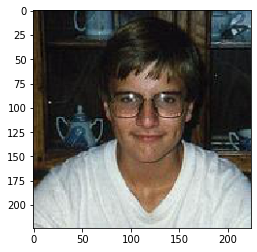

In [15]:
plt.imshow(features[4])

## EDA

In [16]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Text(0.5, 0, 'años')

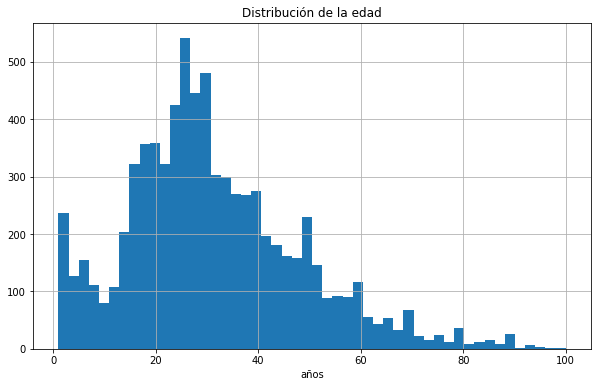

In [17]:
labels["real_age"].hist(bins=50, figsize=(10,6))
plt.title("Distribución de la edad")
plt.xlabel("años")

In [18]:
def age_group(real_age):
    if real_age < 21:
        return "edad no permitida"
    return "edad legal"

<AxesSubplot:>

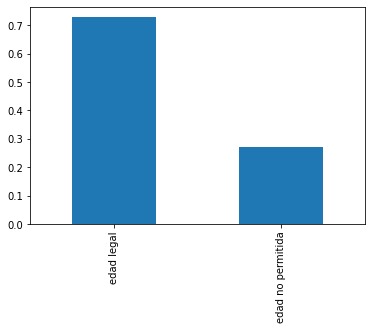

In [19]:
labels_copy = labels
labels_copy["age_group"] = labels_copy["real_age"].apply(age_group)
labels_copy["age_group"].value_counts(normalize=True).plot(kind="bar")

<AxesSubplot:>

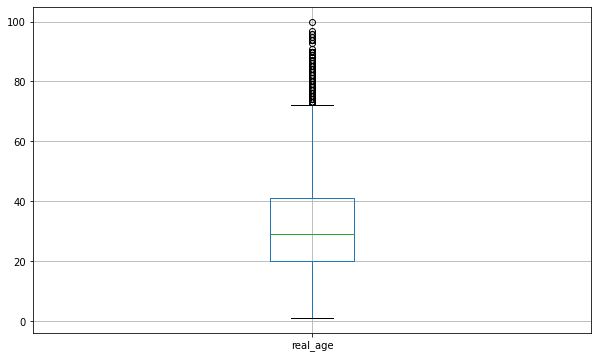

In [20]:
labels.boxplot(figsize=(10,6))

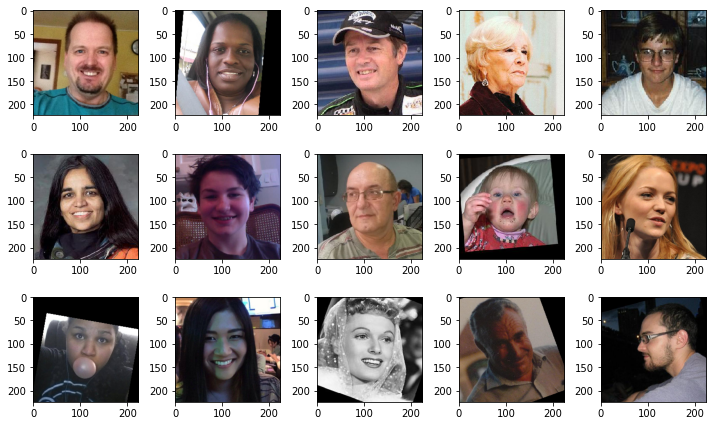

In [39]:
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(5, 5, i+1)
    plt.imshow(features[i])
    plt.tight_layout()

### Conclusiones

1. La data suministrada cuenta con 7591 registros, 2 columnas, sin datos ausentes.
2. La edad muestra asimetría positiva con la mayor concentración de datos entre los 15 y 50 años, mostrando un pico entre 22 y 30 años. 
3. En el boxplot se aprecia que hay datos atípicos por encima de los 70 años.
4. El 73% de los compradores son mayores de la edad legal permitida de 21 años mientras que el 23% está por debajo de la edad en cuestión.

## Modelado

In [ ]:
def load_train(path):
    
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    """
    
    labels=pd.read_csv(path + "labels.csv")
    train_datagen = ImageDataGenerator(validation_split=0.2, rescale=1.0/255)
    train_gen_flow = train_datagen.flow_from_dataframe(dataframe=labels, directory= path + "final_files/", x_col = "file_name", y_col="real_age", target_size = (224, 224), class_mode='raw', batch_size=32, seed=12345)


    return train_gen_flow

In [ ]:
def load_test(path):
    
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta
    """
    
    labels=pd.read_csv(path + "labels.csv")
    test_datagen = ImageDataGenerator(validation_split=0.2, rescale=1.0/255)
    test_gen_flow = test_datagen.flow_from_dataframe(dataframe=labels, directory= path + "final_files/", x_col = "file_name", y_col="real_age", target_size = (224, 224), class_mode='raw', batch_size=32, seed=12345)


    return test_gen_flow

In [ ]:
def create_model(input_shape):
    
    """
    Define el modelo
    """
    
    backbone = ResNet50(input_shape=input_shape, weights="imagenet", include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation="relu"))
    optimizer=Adam(lr=0.0001)
    model.compile(loss="mse", optimizer=optimizer, metrics=["mae"])

    return model

In [ ]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Entrena el modelo dados los parámetros
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, validation_data=test_data, batch_size=None, epochs=epochs, steps_per_epoch=None, validation_steps=None)


    return model

### El resultado

Using TensorFlow backend.
Found 7591 validated image filenames.
Found 7591 validated image filenames.
Train for 238 steps, validate for 238 steps

Epoch 1/20 238/238 96s 403ms/step - loss: 188.6803 - mae: 9.8423 - val_loss: 904.6716 - val_mae: 25.26

Epoch 2/20 238/238 77s 322ms/step - loss: 58.1539 - mae: 5.7617 - val_loss: 739.5433 - val_mae: 22.1847

Epoch 3/20 238/238 77s 322ms/step - loss: 30.9761 - mae: 4.2217 - val_loss: 98.8094 - val_mae: 7.6242

Epoch 4/20 238/238 77s 322ms/step - loss: 20.8616 - mae: 3.4605 - val_loss: 28.3504 - val_mae: 4.1873

Epoch 5/20 238/238 77s 322ms/step - loss: 15.3194 - mae: 2.9731 - val_loss: 17.4042 - val_mae: 3.1833

Epoch 6/20 238/238 77s 323ms/step - loss: 12.0316 - mae: 2.6113 - val_loss: 19.7317 - val_mae: 3.4723

Epoch 7/20 238/238 76s 321ms/step - loss: 9.1317 - mae: 2.2937 - val_loss: 11.7191 - val_mae: 2.5498

Epoch 8/20 238/238 77s 322ms/step - loss: 8.7819 - mae: 2.2333 - val_loss: 12.0366 - val_mae: 2.5932

Epoch 9/20 238/238 77s 322ms/step - loss: 8.5233 - mae: 2.1974 - val_loss: 29.5051 - val_mae: 4.4705

Epoch 10/20 238/238 76s 321ms/step - loss: 7.9565 - mae: 2.1213 - val_loss: 17.8151 - val_mae: 3.2070

Epoch 11/20 238/238 76s 321ms/step - loss: 7.5617 - mae: 2.0596 - val_loss: 15.9890 - val_mae: 2.9925

Epoch 12/20 238/238 77s 322ms/step - loss: 6.7694 - mae: 1.9663 - val_loss: 10.1186 - val_mae: 2.4044

Epoch 13/20 238/238 77s 322ms/step - loss: 6.1596 - mae: 1.8544 - val_loss: 10.4983 - val_mae: 2.4300

Epoch 14/20 238/238 77s 322ms/step - loss: 5.6827 - mae: 1.7853 - val_loss: 8.9680 - val_mae: 2.2499

Epoch 15/20 238/238 77s 322ms/step - loss: 5.6705 - mae: 1.7876 - val_loss: 7.7444 - val_mae: 2.0532

Epoch 16/20 238/238 77s 322ms/step - loss: 5.6653 - mae: 1.7992 - val_loss: 10.2547 - val_mae: 2.3849

Epoch 17/20 238/238 77s 321ms/step - loss: 5.5891 - mae: 1.7992 - val_loss: 16.4443 - val_mae: 3.1909

Epoch 18/20 238/238 76s 321ms/step - loss: 5.9470 - mae: 1.8358 - val_loss: 12.7830 - val_mae: 2.6926

Epoch 19/201 238/238 76s 321ms/step - loss: 6.0494 - mae: 1.8571 - val_loss: 10.0078 - val_mae: 2.3883

Epoch 20/20 238/238 77s 322ms/step - loss: 5.7371 - mae: 1.7855 - val_loss: 9.3583 - val_mae: 2.2987

 
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
  
238/238 - 38s - loss: 9.3583 - mae: 2.2987

Test MAE: 2.2987

(1.0, 20.0)

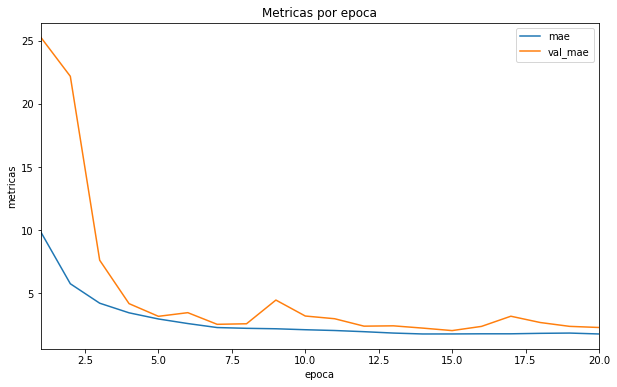

In [45]:
datos=[[1, 9.8423, 25.26],
      [2, 5.7617, 22.1847],
      [3, 4.2217, 7.6242],
      [4, 3.4605, 4.1873],
      [5, 2.9731, 3.1833],
      [6, 2.6113, 3.4723],
      [7, 2.2937, 2.5498],
      [8, 2.2333, 2.5932],
      [9, 2.1974, 4.4705],
      [10, 2.1213, 3.2070],
      [11, 2.0596, 2.9925],
      [12, 1.9663, 2.4044],
      [13, 1.8574, 2.4300],
      [14, 1.7853, 2.2499],
      [15, 1.7876, 2.0532],
      [16, 1.7992, 2.3849],
      [17, 1.7992, 3.1909],
      [18, 1.8358, 2.6926],
      [19, 1.8571, 2.3883],
      [20, 1.7855, 2.2987]]
col = ["epoch", "mae", "val_mae"]
tabla = pd.DataFrame(data=datos, columns=col)
tabla.plot(x="epoch", figsize=(10,6))
plt.title("Metricas por epoca")
plt.xlabel("epoca")
plt.ylabel("metricas")
plt.xlim(1,20)


## Conclusiones

1. Los resultados muestran que el error es de 2.29, es decir el modelo predecira 2 años por arriba o por debajo de la edad real, lo cual está bastante bien.
2. Desde la etapa 11 el error se mantiene en el mismo orden en la muestra de validación.